In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import getpass
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [2]:
client_id = str(getpass.getpass('client_id?'))
client_sectret = str(getpass.getpass('client_secret?'))
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
    client_id=client_id, client_secret=client_sectret))

In [3]:
def all_albums_from_artist(artist_id):
    albums_ids = []
    albums = sp.artist_albums(artist_id)
    for album in range(len(albums['items'])):
        albums_ids.append(albums['items'][album]['id'])
    return list(set(albums_ids))

In [4]:
def all_songs_from_albums(albums_id_list):
    ids = []
    for album_id in tqdm(albums_id_list):
        songs_ids = sp.album_tracks(album_id)
        for id in range(len(songs_ids['items'])):
            ids.append(songs_ids['items'][id]['id'])         
    ids_chunks = []
    for i in tqdm(range(0, len(ids), 100)):
        ids_chunks.append(ids[i:i + 100])
    audio_feat = []
    for i in tqdm(ids_chunks):
        audio_feat.append(sp.audio_features(tracks=i))
    audio_feat_total = []
    for i in tqdm(range(len(audio_feat))):
        audio_feat_total += audio_feat[i]
    audio_feats_clean = [dct for dct in audio_feat_total if dct]
    df = pd.DataFrame(audio_feats_clean)
    return df.drop(['type', 'track_href', 'uri', 'analysis_url'], axis=1)
    

In [5]:
def release_year(df):
    years = []
    for id in tqdm(df['id']):
        track = sp.track(id)
        years.append(track['album']['release_date'][0:4])
    return years

In [6]:
def fix_tempo(df):
    df['tempo'] = df['tempo'].apply(lambda x: x*2 if x < 60 else x)
    df['tempo'] = df['tempo'].apply(lambda x: x/2 if x > 200 else x)
    df['tempo'] = df['tempo'].apply(lambda x: 120 if x == 0 else x)
    return df

In [7]:
def genre_predict():
    artist_name = input('Enter artist name:')
    print('Listening to', artist_name.upper())
    artist = sp.search(artist_name)
    artist_id = artist['tracks']['items'][0]['artists'][0]['id']
    albums = all_albums_from_artist(artist_id)
    songs = all_songs_from_albums(albums)
    print("I've just heard", len(songs), 'songs')
    songs = fix_tempo(songs)
    X = songs.drop(['id'], axis=1)
    prediction = forest_model.predict(X)
    pred_genres = np.unique(prediction, return_counts=True)
    genres_list = ['jazz', 'rock', 'hip-hop', 'pop', 'electronic']
    genres_dict = dict(zip(pred_genres[0], pred_genres[1]))
    if len(genres_dict) > 1:
        genres_sorted = sorted(genres_dict.items(), key=lambda x: x[1], reverse=True)
        main_genre = genres_list[int(genres_sorted[0][0])-1]
        print('Sounds like', artist_name.upper(), 'plays', main_genre, 'music')
    else:
        print('Sounds like', artist_name.upper(), 'plays', genres_list[int(pred_genres[0])-1], 'music')

In [8]:
def genre_predict2():
    #predictor function with release year
    artist_name = input('Enter artist name:')
    print('Listening to', artist_name.upper())
    artist = sp.search(artist_name)
    artist_id = artist['tracks']['items'][0]['artists'][0]['id']
    albums = all_albums_from_artist(artist_id)
    songs = all_songs_from_albums(albums)
    print("I've just heard", len(songs), 'songs')
    print('Getting release years (can take a while)')
    songs['year'] = release_year(songs)
    songs = fix_tempo(songs)
    X = songs.drop(['id'], axis=1)
    prediction = forest_model2.predict(X)
    pred_genres = np.unique(prediction, return_counts=True)
    genres_list = ['jazz', 'rock', 'hip-hop', 'pop', 'electronic']
    genres_dict = dict(zip(pred_genres[0], pred_genres[1]))
    if len(genres_dict) > 1:
        genres_sorted = sorted(genres_dict.items(), key=lambda x: x[1], reverse=True)
        main_genre = genres_list[int(genres_sorted[0][0])-1]
        print('Sounds like', artist_name.upper(), 'plays', main_genre, 'music')
    else:
        print('Sounds like', artist_name.upper(), 'plays', genres_list[int(pred_genres[0])-1], 'music')

In [9]:
music = pd.read_csv('data/music.csv')

<AxesSubplot:>

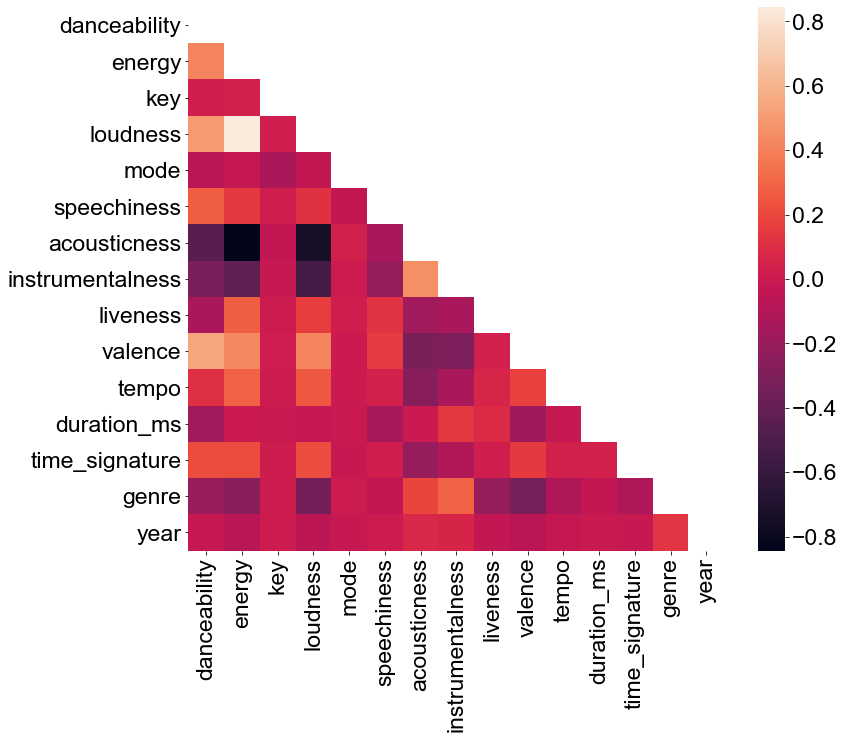

In [151]:
fig, axes = plt.subplots(figsize=(12, 10))
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 23}
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.rc('font', **font)
corr = music.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, mask=mask)

In [146]:
music.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142711 entries, 0 to 142710
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   danceability      142711 non-null  float64
 1   energy            142711 non-null  float64
 2   key               142711 non-null  int64  
 3   loudness          142711 non-null  float64
 4   mode              142711 non-null  int64  
 5   speechiness       142711 non-null  float64
 6   acousticness      142711 non-null  float64
 7   instrumentalness  142711 non-null  float64
 8   liveness          142711 non-null  float64
 9   valence           142711 non-null  float64
 10  tempo             142711 non-null  float64
 11  id                142711 non-null  object 
 12  duration_ms       142711 non-null  int64  
 13  time_signature    142711 non-null  int64  
 14  genre             142711 non-null  int64  
 15  year              142711 non-null  int64  
dtypes: float64(9), int64

In [10]:
music.drop(['Unnamed: 0'], axis=1, inplace=True)
music = music.drop(music[(music['genre'] == 5) & (music['year'] < 1990)].index)
music.reset_index(drop=True, inplace=True)

In [11]:
music['genre'].value_counts()

5    37658
2    34062
4    26390
1    25968
3    18633
Name: genre, dtype: int64

In [12]:
#music.to_csv('data/music_final.csv', index=False)

# It 1

In [13]:
y = music['genre']
X = music.drop(['genre', 'id', 'year'], axis=1)

In [14]:
r_tree = RandomForestClassifier(n_estimators=152, max_depth=203, max_features='auto', bootstrap=False)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)
forest_model = r_tree.fit(X_train, y_train)
y_pred = forest_model.predict(X_test)
accuracy_score(y_test, y_pred)

In [15]:
clf_report = classification_report(y_test, y_pred)
print(clf_report)

              precision    recall  f1-score   support

           1       0.83      0.82      0.83      7887
           2       0.85      0.85      0.85     10179
           3       0.83      0.86      0.84      5538
           4       0.85      0.80      0.83      7964
           5       0.90      0.93      0.92     11246

    accuracy                           0.86     42814
   macro avg       0.85      0.85      0.85     42814
weighted avg       0.86      0.86      0.86     42814



In [64]:
param_grid = [
{'bootstrap': [False], 'n_estimators': range(100, 200), 'max_depth': range(30, 300), 
'max_features': ['auto', 'sqrt', 'log2']},]
forest_class = RandomForestClassifier()
grid_random = RandomizedSearchCV(forest_class, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
grid_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions=[{'bootstrap': [False],
                                         'max_depth': range(30, 300),
                                         'max_features': ['auto', 'sqrt',
                                                          'log2'],
                                         'n_estimators': range(100, 200)}],
                   return_train_score=True, scoring='neg_mean_squared_error')

In [65]:
cvres = grid_random.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.9266740412006719 {'n_estimators': 184, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
0.9275378698372042 {'n_estimators': 191, 'max_features': 'log2', 'max_depth': 82, 'bootstrap': False}
0.9283091464002605 {'n_estimators': 181, 'max_features': 'log2', 'max_depth': 101, 'bootstrap': False}
0.923454737564431 {'n_estimators': 152, 'max_features': 'auto', 'max_depth': 203, 'bootstrap': False}
0.9284169407527151 {'n_estimators': 154, 'max_features': 'sqrt', 'max_depth': 92, 'bootstrap': False}
0.9296776595213949 {'n_estimators': 170, 'max_features': 'log2', 'max_depth': 152, 'bootstrap': False}
0.9258689065039226 {'n_estimators': 179, 'max_features': 'auto', 'max_depth': 238, 'bootstrap': False}
0.9249873322517723 {'n_estimators': 169, 'max_features': 'sqrt', 'max_depth': 264, 'bootstrap': False}
0.9276672565147991 {'n_estimators': 123, 'max_features': 'auto', 'max_depth': 285, 'bootstrap': False}
0.9276565599115458 {'n_estimators': 118, 'max_features': 'log2', 'max_depth':

In [66]:
param_grid = [
{'bootstrap': [False], 'max_features': ['sqrt', 'auto'], 
'n_estimators': [179, 169, 152], 'max_depth': [203, 264, 238]},]
forest_class = RandomForestClassifier()
grid_search = GridSearchCV(forest_class, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'bootstrap': [False], 'max_depth': [203, 264, 238],
                          'max_features': ['sqrt', 'auto'],
                          'n_estimators': [179, 169, 152]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [68]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.9235305917463078 {'bootstrap': False, 'max_depth': 203, 'max_features': 'sqrt', 'n_estimators': 179}
0.927122199005623 {'bootstrap': False, 'max_depth': 203, 'max_features': 'sqrt', 'n_estimators': 169}
0.9268738990070701 {'bootstrap': False, 'max_depth': 203, 'max_features': 'sqrt', 'n_estimators': 152}
0.9235089129771112 {'bootstrap': False, 'max_depth': 203, 'max_features': 'auto', 'n_estimators': 179}
0.9267226744397411 {'bootstrap': False, 'max_depth': 203, 'max_features': 'auto', 'n_estimators': 169}
0.9225979509302774 {'bootstrap': False, 'max_depth': 203, 'max_features': 'auto', 'n_estimators': 152}
0.9255282479588417 {'bootstrap': False, 'max_depth': 264, 'max_features': 'sqrt', 'n_estimators': 179}
0.9295214632261419 {'bootstrap': False, 'max_depth': 264, 'max_features': 'sqrt', 'n_estimators': 169}
0.9261445397298806 {'bootstrap': False, 'max_depth': 264, 'max_features': 'sqrt', 'n_estimators': 152}
0.925658133396836 {'bootstrap': False, 'max_depth': 264, 'max_features': '

In [67]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=203, n_estimators=152)

# Iteration 2 - including release years

In [16]:
y2 = music['genre']
X2 = music.drop(['genre', 'id'], axis=1)

In [17]:
r_tree2 = RandomForestClassifier(n_estimators=135, max_depth=226, max_features='auto', bootstrap=False)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=40)
forest_model2 = r_tree2.fit(X_train2, y_train2)
y_pred2 = forest_model2.predict(X_test2)
accuracy_score(y_test2, y_pred2)

0.8744803101789135

In [136]:
target_names = ['Jazz', 'Rock', 'Hip-Hop', 'Pop', 'Electronic']
clf_report = classification_report(y_test2, y_pred2, 
                                   target_names=target_names,
                                   output_dict=True)

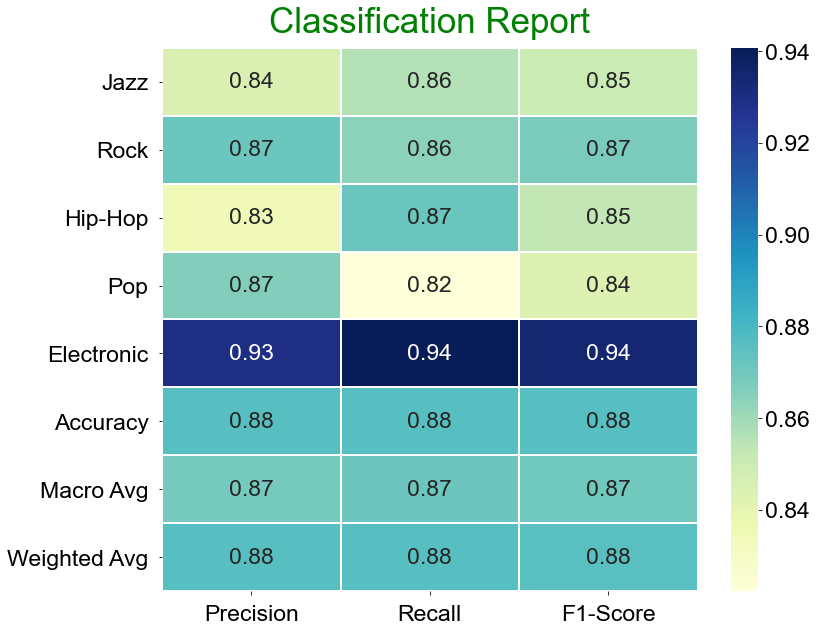

In [145]:
fig, axes = plt.subplots(figsize=(12, 10))
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 23}

plt.rc('font', **font)
plt.title('Classification Report', fontsize=35,
          color="green", pad=15)
xticks = ['Precision', 'Recall', 'F1-Score']
yticks = target_names + ['Accuracy', 'Macro Avg', 'Weighted Avg']
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="YlGnBu", linewidths=2, xticklabels=xticks, yticklabels=yticks)
plt.yticks(rotation=0)
axes.tick_params(axis='both', which='major', pad=10)

In [116]:
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': forest_model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi

,feature,importance
6,acousticness,0.147378
3,loudness,0.128887
0,danceability,0.116385
5,speechiness,0.099896
1,energy,0.097249
7,instrumentalness,0.087179
11,duration_ms,0.086138
9,valence,0.080717
8,liveness,0.057367
10,tempo,0.054873


In [34]:
param_grid = [
{'n_estimators': range(10, 300), 'max_depth': range(30, 300), 'max_features': ['auto', 'sqrt', 'log2']},
{'bootstrap': [False], 'n_estimators': range(10, 300), 'max_depth': range(30, 300), 
'max_features': ['auto', 'sqrt', 'log2']},]
forest_class = RandomForestClassifier()
grid_random = RandomizedSearchCV(forest_class, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
grid_random.fit(X_train2, y_train2)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions=[{'max_depth': range(30, 300),
                                         'max_features': ['auto', 'sqrt',
                                                          'log2'],
                                         'n_estimators': range(10, 300)},
                                        {'bootstrap': [False],
                                         'max_depth': range(30, 300),
                                         'max_features': ['auto', 'sqrt',
                                                          'log2'],
                                         'n_estimators': range(10, 300)}],
                   return_train_score=True, scoring='neg_mean_squared_error')

In [35]:
grid_random.best_params_

{'n_estimators': 135,
 'max_features': 'auto',
 'max_depth': 226,
 'bootstrap': False}

In [ ]:
cvres = grid_random.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
param_grid = [
{'bootstrap': [False], 'max_features': ['log2'], 'n_estimators': [154, 175, 192], 'max_depth': [35, 124, 185]},
]
forest_class = RandomForestClassifier()
grid_search = GridSearchCV(forest_class, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(X_train2, y_train2)

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
grid_search.best_estimator_

In [32]:
genre_predict()

Listening to MANOLO ESCOBAR


100%|██████████| 5/5 [00:00<00:00, 742.93it/s]


I've just heard 418 songs
Sounds like MANOLO ESCOBAR plays jazz music
